In [206]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt

# Import and Concatenate Data

In [207]:
# We assume there is an equal amount of the labels
data_length = 370

In [208]:
feature_df = pd.DataFrame(index=range(data_length))

for data_type in ["EEG", "EMG"]:
    train_feature_df = pd.read_csv("Features/Train_"+str(data_type)+"_Topological_Summary_Statistics.csv")
    train_advanced_feature_df = pd.read_csv("Features/Train_"+str(data_type)+"_Advanced_Features.csv")
    train_statistical_features = pd.read_csv("Features/Train_"+str(data_type)+"_Statistical_Features.csv")
    train_wasserstein_features = pd.read_csv("Features/Train_"+str(data_type)+"_Wasserstein_Features.csv")
    #train_landscape_features = pd.read_csv("Features/Train_"+str(data_type)+"_Landscape_Features.csv")
    #train_bottleneck_features = pd.read_csv("Features/Train_"+str(data_type)+"_bottleneck_Features.csv")
    train_signature_features = pd.read_csv("Features/Train_"+str(data_type)+"_Signature_Statistics.csv")
    train_vectorization_features = pd.read_csv("Features/Train_"+str(data_type)+"_Vectorization_Features.csv")


    test_feature_df = pd.read_csv("Features/Test_"+str(data_type)+"_Topological_Summary_Statistics.csv")
    test_advanced_feature_df = pd.read_csv("Features/Test_"+str(data_type)+"_Advanced_Features.csv")
    test_statistical_features = pd.read_csv("Features/Test_"+str(data_type)+"_Statistical_Features.csv")
    test_wasserstein_features = pd.read_csv("Features/Test_"+str(data_type)+"_Wasserstein_Features.csv")
    #test_landscape_features = pd.read_csv("Features/Test_"+str(data_type)+"_Landscape_Features.csv")
    #test_bottleneck_features = pd.read_csv("Features/Test_"+str(data_type)+"_bottleneck_Features.csv")
    test_signature_features = pd.read_csv("Features/Test_"+str(data_type)+"_Signature_Statistics.csv")
    test_vectorization_features = pd.read_csv("Features/Test_"+str(data_type)+"_Vectorization_Features.csv")

    
    # Concatenate train and test sets (and split again later) to not get a problem with indices
    summary_statistics = pd.concat([train_feature_df, test_feature_df], ignore_index=True)
    advanced_features = pd.concat([train_advanced_feature_df, test_advanced_feature_df], ignore_index=True)
    statistical_features = pd.concat([train_statistical_features, test_statistical_features], ignore_index=True)
    wasserstein_features =  pd.concat([train_wasserstein_features, test_wasserstein_features], ignore_index=True)
    #landscape_features =  pd.concat([train_landscape_features, test_landscape_features], ignore_index=True)
    #bottleneck_features =  pd.concat([train_bottleneck_features, test_bottleneck_features], ignore_index=True)
    signature_features =  pd.concat([train_signature_features, test_signature_features], ignore_index=True)
    vectorization_features =  pd.concat([train_vectorization_features, test_vectorization_features], ignore_index=True)

    # Save labels for later
    labels = summary_statistics["Label"]

    list_of_dataframes =  [summary_statistics, wasserstein_features, statistical_features, advanced_features, \
                           vectorization_features, signature_features]

    for df in list_of_dataframes:
        # We do not want the labels in the training data
        df.drop(columns = ["Label"], inplace = True)
        # All dataframes come with unnamed columns TODO
        df.drop(df.columns[df.columns.str.contains('unnamed',case = False)], axis = 1, inplace = True)

    # Choose one, several or all of the following dataframes
    feature_df = feature_df.join(summary_statistics) # improves result slightly
    feature_df = feature_df.join(statistical_features) # improves result slightly, but not with all random_states
    feature_df = feature_df.join(wasserstein_features) # only improves result if advanced_features is not used
    feature_df = feature_df.join(advanced_features) # improves result by a lot, also works well alone
    #feature_df = feature_df.join(bottleneck_features) # good standalone accuracy
    feature_df = feature_df.join(signature_features) # currently not a good result
    feature_df = feature_df.join(vectorization_features) 

In [209]:
# Save dataframe for data exploration
feature_df.to_csv("Features/All_Features.csv")

# Preprocess Data

In [210]:
#TODO the whole splitting procedure has to be done differently

In [211]:
# Split data frame again (for each label)
train_label_length = int(0.7*(data_length/5))
train_data_length = train_label_length*5

test_label_length = int(0.7*(data_length/5))+1
test_data_length = test_label_length*5

X_train = pd.DataFrame()
y_train = []

X_test = pd.DataFrame()
y_test = []

for label_idx in range(5):
    X_train = pd.concat([X_train, feature_df[train_label_length*label_idx:train_label_length*(label_idx+1)]], ignore_index=True)
    y_train.extend(labels[train_label_length*label_idx:train_label_length*(label_idx+1)])

    X_test = pd.concat([X_test, feature_df[train_label_length+test_label_length*label_idx:train_label_length+test_label_length*(label_idx+1)]])
    y_test.extend(labels[train_label_length+test_label_length*label_idx:train_label_length+test_label_length*(label_idx+1)])




In [212]:
# Random Forest

In [213]:
rf = RandomForestClassifier(random_state=8, n_estimators = 70)
rf.fit(X_train, y_train)

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


RandomForestClassifier(n_estimators=70, random_state=8)

In [214]:
y_pred = rf.predict(X_test)

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [215]:
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9615384615384616


/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_99179/3917715269.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forest_importances[feature_indices].plot.bar(yerr=std[feature_indices], ax=ax)


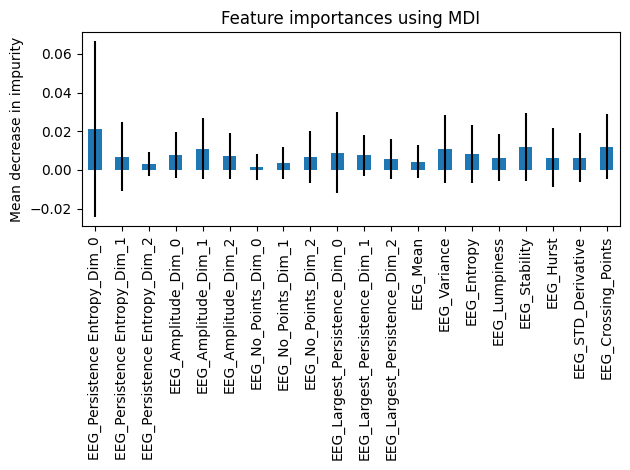

In [216]:
feature_indices = np.arange(0,20)
#feature_indices = np.arange(20,40)
#feature_indices = np.arange(40,60) 
#feature_indices = np.arange(60,80)
#feature_indices = np.arange(80,100)



importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)


fig, ax = plt.subplots()
forest_importances[feature_indices].plot.bar(yerr=std[feature_indices], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [217]:
forest_importances = pd.Series(importances, index=feature_df.columns)

# Filter features that are not important and sometimes have a negative effect
not_important = forest_importances[(forest_importances < 0.002) & (std > 0.001)].index.tolist()

# Print or use the names of features with negative importance
print("Features with no feature importance:", not_important)

Features with no feature importance: ['EEG_No_Points_Dim_0', 'EEG_BC_Vectorization_Dim_0Coord_2', 'EEG_BC_Vectorization_Dim_2Coord_1', 'EEG_SH_Vectorization_Dim_1Coord_1', 'EEG_SH_Vectorization_Dim_2Coord_1', 'EEG_PL_Vectorization_Dim_2Coord_1', 'EMG_Amplitude_Dim_0', 'EMG_Amplitude_Dim_1', 'EMG_Amplitude_Dim_2', 'EMG_Largest_Persistence_Dim_0', 'EMG_Largest_Persistence_Dim_2', 'EMG_Distance_to_wasserstein_Barycenter1', 'EMG_Distance_to_wasserstein_Barycenter2', 'EMG_Distance_to_wasserstein_Barycenter4', 'EMG_wasserstein_Distance_to_Origin_Diagram', 'EMG_L1_Norm_BCDim2', 'EMG_HK_Vectorization_Dim_0Coord_2', 'EMG_HK_Vectorization_Dim_1Coord_0', 'EMG_HK_Vectorization_Dim_1Coord_2', 'EMG_HK_Vectorization_Dim_2Coord_0', 'EMG_HK_Vectorization_Dim_2Coord_2', 'EMG_HK_Vectorization_Dim_2Coord_3', 'EMG_BC_Vectorization_Dim_1Coord_0', 'EMG_BC_Vectorization_Dim_1Coord_2', 'EMG_BC_Vectorization_Dim_1Coord_3', 'EMG_BC_Vectorization_Dim_2Coord_0', 'EMG_BC_Vectorization_Dim_2Coord_2', 'EMG_BC_Vectori

In [218]:
for feature in not_important:
    feature_df.drop(columns = feature, inplace = True)

In [219]:
# Split data frame again (for each label)
train_label_length = int(0.7*(data_length/5))
train_data_length = train_label_length*5

test_label_length = int(0.7*(data_length/5))+1
test_data_length = test_label_length*5

X_train = pd.DataFrame()
y_train = []

X_test = pd.DataFrame()
y_test = []

for label_idx in range(5):
    X_train = pd.concat([X_train, feature_df[train_label_length*label_idx:train_label_length*(label_idx+1)]], ignore_index=True)
    y_train.extend(labels[train_label_length*label_idx:train_label_length*(label_idx+1)])

    X_test = pd.concat([X_test, feature_df[train_label_length+test_label_length*label_idx:train_label_length+test_label_length*(label_idx+1)]])
    y_test.extend(labels[train_label_length+test_label_length*label_idx:train_label_length+test_label_length*(label_idx+1)])




In [220]:
rf = RandomForestClassifier(random_state=8, n_estimators = 70)
rf.fit(X_train, y_train)

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


RandomForestClassifier(n_estimators=70, random_state=8)

In [221]:
y_pred = rf.predict(X_test)

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [222]:
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9769230769230769


In [29]:
# XGBoost

In [12]:
model = xgb.XGBClassifier(eta = 0.3, max_depth = 8, alpha = 0.3, grow_policy = "lossguide", max_leaves = 100)

#Training the model on the training data
model.fit(X_train, y_train)

#Making predictions on the test set
predictions = model.predict(X_test)

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)

Accuracy: 0.9192307692307692
